# Projeto 3 - Ciência dos Dados - Regressão & Criptomoedas

**Alunos** :  Lucas Muchaluat, Luiz Vitor Germanos e Matheus Ferreira

**Turma** :  Engenharia 2B

### Introdução

 Nesse documento você encontrará uma análise sobre a relação entre o bitcoin e o ouro em uma tentativa de prever o preço do ouro (Spot) baseado no preço do bitcoin. Partimos da premissa que ambos os ativos servem como _____ e portanto teriam algum tipo de correlação. Nossa análise consiste em fazer regressões e a partir das regressões validar as relações entre os dois ativos. 

**Pergunta norteadora:**

### Importando as bibliotecas

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm, probplot
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
# # plt.style.use('ggplot')

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Obtendo as bases de dados 

In [2]:
#lendo informação obtida no site coinmarketcap.com
cmc_2017 = pd.read_csv("coinmarketcap_06122017.csv")
#imprimindo as primeiras linhas do dataset
cmc_2017.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,9.007640e+09,1.672352e+07,bitcoin,1512549554,2.130493e+11,2.100000e+07,Bitcoin,0.12,7.33,17.45,1.000000,12739.500000,1,BTC,1.672352e+07
1,1,1.551330e+09,9.616537e+07,ethereum,1512549553,4.352945e+10,NaN,Ethereum,-0.18,-3.93,-7.33,0.036177,452.652000,2,ETH,9.616537e+07
2,2,1.111350e+09,1.684044e+07,bitcoin-cash,1512549578,2.529585e+10,2.100000e+07,Bitcoin Cash,1.65,-5.51,-4.75,0.120050,1502.090000,3,BCH,1.684044e+07
3,3,2.936090e+09,2.779530e+09,iota,1512549571,1.475225e+10,2.779530e+09,IOTA,-2.38,83.35,255.82,0.000424,5.307460,4,MIOTA,2.779530e+09
4,4,2.315050e+08,3.873915e+10,ripple,1512549541,9.365343e+09,1.000000e+11,Ripple,0.56,-3.70,-14.79,0.000019,0.241754,5,XRP,9.999309e+10


In [3]:
#realizando os mesmos passos feitos acima para 2018
cmc_2018 = pd.read_csv("coinmarketcap_06012018.csv")
cmc_2018.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,22081300000,16785225,bitcoin,1515230661,284909052105,2.100000e+07,Bitcoin,-0.42,5.76,26.04,1.000000,16973.800000,1,BTC,16785225
1,1,5221370000,38739144847,ripple,1515230641,119207709132,1.000000e+11,Ripple,-0.26,-9.23,24.15,0.000186,3.077190,2,XRP,99993093880
2,2,5705690000,96803840,ethereum,1515230649,100115499075,NaN,Ethereum,0.29,-1.04,45.01,0.062517,1034.210000,3,ETH,96803840
3,3,1569900000,16896225,bitcoin-cash,1515230652,44424061657,2.100000e+07,Bitcoin Cash,0.03,7.99,2.81,0.158934,2629.230000,4,BCH,16896225
4,4,428305000,25927070538,cardano,1515230654,25916647856,4.500000e+10,Cardano,0.39,-5.87,64.99,0.000060,0.999598,5,ADA,31112483745


In [4]:
#listando as colunas do dataset
list(cmc_2017)

['Unnamed: 0',
 '24h_volume_usd',
 'available_supply',
 'id',
 'last_updated',
 'market_cap_usd',
 'max_supply',
 'name',
 'percent_change_1h',
 'percent_change_24h',
 'percent_change_7d',
 'price_btc',
 'price_usd',
 'rank',
 'symbol',
 'total_supply']

### Recortando e preparando os datasets

In [5]:
# Selecionando as colunas 'name' e 'market_cap_usd'
market_cap_2017 = cmc_2017[['name', 'market_cap_usd']]
market_cap_2018 = cmc_2018[['name', 'market_cap_usd']]

# Contando o número de valores de cada uma delas
market_cap_2017.count()

name              1326
market_cap_usd    1031
dtype: int64

 Como existem mais "id" que "market caps" podemos concluir que existem moedas sem um share no mercado

In [6]:
# Filtrando as linhas sem um market capitalization
# market_cap = market_cap.query('market_cap_usd > 0')
market_cap_2017 = market_cap_2017[market_cap_2017["market_cap_usd"]>0]
market_cap_2018 = market_cap_2018[market_cap_2018["market_cap_usd"]>0]

# Contando o número de valores novamente
market_cap_2017.count()

name              1031
market_cap_usd    1031
dtype: int64

### Analisando o tamanho de cada moeda no mercado

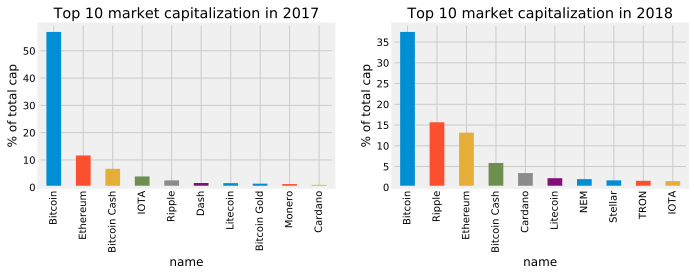

In [7]:
# Selecionando as 10 primeiras linhas e setando o index via nome da moeda
market_cap10_2017 = market_cap_2017.head(10).set_index('name')
market_cap10_2018 = market_cap_2018.head(10).set_index('name')

# Calculando porcentagem do market cap da moeda em relação ao total
market_cap10_2017 = market_cap10_2017.assign(market_cap_perc_2017 = lambda x: (x["market_cap_usd"] / market_cap_2017["market_cap_usd"].sum()) * 100)
market_cap10_2018 = market_cap10_2018.assign(market_cap_perc_2018 = lambda x: (x["market_cap_usd"] / market_cap_2018["market_cap_usd"].sum()) * 100)

# Plotando o gráfico de barras para analisar o tamanho que cada moeda tem no mercado de criptos
plt.figure(figsize=(16,3))
plt.subplot(131)
plot = market_cap10_2017.market_cap_perc_2017.plot.bar(title='Top 10 market capitalization in 2017')
plot.set_ylabel('% of total cap')

plt.subplot(132)
plot = market_cap10_2018.market_cap_perc_2018.plot.bar(title='Top 10 market capitalization in 2018')
plot.set_ylabel('% of total cap');

Se formos analisar as top 3 criptomoedas mais dominantes do mercado em ambos os anos, conseguimos perceber uma que domina recorrentemente o mercado: BITCOIN.

### Visualizando inicialmente a moeda em questão

##### Market Info do Bitcoin

In [8]:

bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))

bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0

bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')

bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")

bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-11-22,4611.57,4629.64,4365.64,4365.94,4569370000,75919439809
1,2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047
2,2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320
3,2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692
4,2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643


In [9]:
#adicionando uma coluna da variação no preço do bitcoin a cada dia
bitcoin_market_info['Delta Bitcoin'] = (bitcoin_market_info['Close'] - bitcoin_market_info['Open'])/bitcoin_market_info['Open']
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Delta Bitcoin
0,2018-11-22,4611.57,4629.64,4365.64,4365.94,4569370000,75919439809,-0.053264
1,2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047,0.030597
2,2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320,-0.084718
3,2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692,-0.133307
4,2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643,0.011475


In [10]:
#analisando o closing price do bitcoin
bitcoin_market_info['Close'].describe()

count     2035.000000
mean      2281.212113
std       3442.689847
min         68.430000
25%        320.350000
50%        596.550000
75%       2582.945000
max      19497.400000
Name: Close, dtype: float64

##### Plotando o closing price ao longo do tempo 

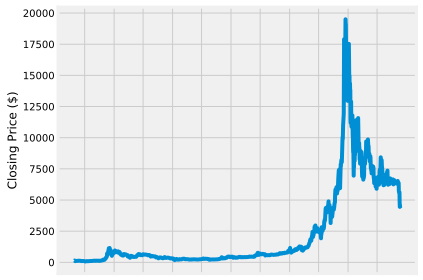

In [11]:
fig, ax1 = plt.subplots(1,1, gridspec_kw = {'height_ratios':[3]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['Close'])
fig.tight_layout()
plt.show()

### Comparando a moeda com o Ouro (XAU)

##### Obtendo os dados a respeito do ouro

In [12]:
Ouro = pd.read_excel('XAU_USD Historical Data (1) 2.xlsx')
Ouro = Ouro.assign(Date=pd.to_datetime(Ouro['Date']))
Ouro["Delta Ouro"] = Ouro["Price"] - Ouro["Open"]
Ouro.set_index('Date',inplace = True)
Ouro.head()

,Price,Open,High,Low,Change %,Delta Ouro
Date,,,,,,
2018-11-21,1225.83,1221.74,1230.12,1219.87,0.0035,4.09
2018-11-20,1221.55,1224.37,1229.17,1219.67,-0.0020,-2.82
2018-11-19,1224.05,1221.76,1225.26,1217.52,0.0012,2.29
2018-11-18,1222.62,1222.49,1222.84,1221.69,0.0009,0.13
2018-11-16,1221.47,1213.02,1225.37,1212.48,0.0070,8.45


##### Cruzando os datasets (Ouro e Bitcoin)

In [13]:
#Cruza as duas tabelas (bitcoin e ouro) via data
bitcoin_market_info.set_index('Date', inplace=True)
# Ouro.set_index('Date', inplace=True)
df = bitcoin_market_info.join(Ouro, how='inner', lsuffix='_btc', rsuffix='_ouro')
df.head(5)

,Open_btc,High_btc,Low_btc,Close,Volume,Market Cap,Delta Bitcoin,Price,Open_ouro,High_ouro,Low_ouro,Change %,Delta Ouro
Date,,,,,,,,,,,,,
2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047,0.030597,1225.83,1221.74,1230.12,1219.87,0.0035,4.09
2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320,-0.084718,1221.55,1224.37,1229.17,1219.67,-0.0020,-2.82
2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692,-0.133307,1224.05,1221.76,1225.26,1217.52,0.0012,2.29
2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643,0.011475,1222.62,1222.49,1222.84,1221.69,0.0009,0.13
2018-11-16,5645.32,5657.02,5498.94,5575.55,5279320000,96900828780,-0.012359,1221.47,1213.02,1225.37,1212.48,0.0070,8.45


### Montando a Regressão

In [14]:
# Função utilitária para fazer a regressão com constante adicionada
def regress_com_const(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [15]:
# Função utilitária para fazer a regressão sem constante adicionada
def regress_sem_const(X,Y):
    model = sm.OLS(Y,X)
    results = model.fit()
    return results

##### Regressão Linear Simples (apenas bitcoin)

Aqui vale ressaltar que faz mais sentido analisar a variação diária do preço do bitcoin e do ouro, visto que os resultados saem mais significativos.

In [16]:
#Seleciona os deltas em comparação, além de remover os NaNs
simples = df[['Delta Bitcoin','Delta Ouro']].dropna()

x = simples['Delta Bitcoin']
y = simples['Delta Ouro']

**Regressão feita com a constante adicionada**

In [17]:
results1 = regress_com_const(x,y)
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4464
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.504
Time:                        22:46:13   Log-Likelihood:                -5648.7
No. Observations:                1477   AIC:                         1.130e+04
Df Residuals:                    1475   BIC:                         1.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0865      0.289      0.299      0.765      -0.480       0.654
Delta Bitcoin    -4.1451      6.204     -0.668      0.504     -16.315       8.025
==============================================================================
Omnibus:                      135.314   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.995
Skew:                          -0.027   Prob(JB):                    1.10e-192
Kurtosis:                       6.790   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

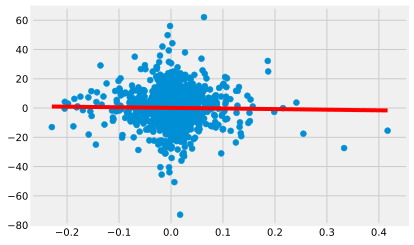

In [18]:
#plotando o gráfico da regressão
x_v = np.linspace(x.min(), x.max(), 500)
x_vc = sm.add_constant(x_v)
y_vc = results1.predict(x_vc)
plt.plot(x_v, y_vc, color="r")
plt.scatter(x,y);

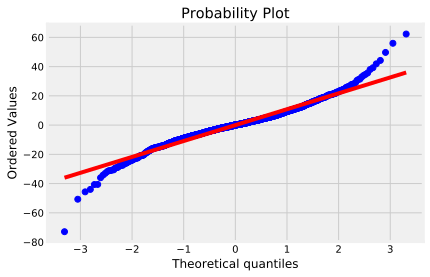

In [19]:
#verificando normalidade dos resíduos
probplot(results1.resid, dist="norm", plot=plt);

**Regressão feita sem a constante adicionada**

In [20]:
results2 = regress_sem_const(x,y)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4261
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.514
Time:                        22:46:19   Log-Likelihood:                -5648.8
No. Observations:                1477   AIC:                         1.130e+04
Df Residuals:                    1476   BIC:                         1.130e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Delta Bitcoin    -4.0425      6.193     -0.653      0.514     -16.190       8.105
==============================================================================
Omnibus:                      135.312   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              883.940
Skew:                          -0.027   Prob(JB):                    1.13e-192
Kurtosis:                       6.790   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
#COMO FAZER GRAFICO SEM A CONSTANTE ADICIONADA?

##### Regressão Linear Múltipla (analisando influência de outras moedas além do bitcoin)

ETHEREUM

In [22]:

ethereum_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

ethereum_market_info = ethereum_market_info.assign(Date=pd.to_datetime(ethereum_market_info['Date']))

ethereum_market_info['Volume'] = ethereum_market_info['Volume'].astype('int64')

ethereum_market_info.columns = ethereum_market_info.columns.str.replace("*", "")
ethereum_market_info['Delta Ethereum'] = (ethereum_market_info['Close'] - ethereum_market_info['Open'])/ethereum_market_info['Open']

ethereum_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Delta Ethereum
0,2018-11-22,136.81,137.74,126.71,126.71,1792150000,13097009562,-0.073825
1,2018-11-21,131.14,138.89,125.76,136.70,2685930000,14127420909,0.042397
2,2018-11-20,148.81,151.25,126.36,130.34,3134410000,13467303239,-0.124118
3,2018-11-19,177.18,177.18,147.85,149.18,2745160000,15410551811,-0.158031
4,2018-11-18,174.18,179.15,174.18,177.07,1810920000,18288411984,0.016592


RIPPLE

In [23]:

ripple_market_info = pd.read_html("https://coinmarketcap.com/currencies/ripple/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

ripple_market_info = ripple_market_info.assign(Date=pd.to_datetime(ripple_market_info['Date']))

ripple_market_info.loc[ripple_market_info['Volume']=="-",'Volume']=0

ripple_market_info['Volume'] = ripple_market_info['Volume'].astype('int64')

ripple_market_info.columns = ripple_market_info.columns.str.replace("*", "")
ripple_market_info['Delta Ripple'] = (ripple_market_info['Close'] - ripple_market_info['Open'])/ripple_market_info['Open']

ripple_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap,Delta Ripple
0,2018-11-22,0.447948,0.448206,0.426080,0.426080,480044000,17182673753,-0.048818
1,2018-11-21,0.436492,0.456144,0.416780,0.447651,858303000,18052574841,0.025565
2,2018-11-20,0.480279,0.496516,0.423672,0.434726,1538310000,17531343950,-0.094847
3,2018-11-19,0.510127,0.510127,0.472305,0.478166,1297340000,19283163673,-0.062653
4,2018-11-18,0.493419,0.522133,0.490330,0.510473,884280000,20557640500,0.034563


##### Juntando os deltas das outras moedas em um unico dataset

In [24]:
ethereum_market_info["Delta Ethereum"].head()

0   -0.073825
1    0.042397
2   -0.124118
3   -0.158031
4    0.016592
Name: Delta Ethereum, dtype: float64

In [36]:
#ethereum_market_info.set_index('Date',inplace = True)
DeltaBit = pd.DataFrame(bitcoin_market_info["Delta Bitcoin"])
DeltaEth = pd.DataFrame(ethereum_market_info["Delta Ethereum"])
DeltaOur = pd.DataFrame(Ouro["Delta Ouro"])
DeltaRip = pd.DataFrame(ripple_market_info["Delta Ripple"])
#pd.concat([DeltaBit,DeltaOur,DeltaEth])
multipla = pd.concat([DeltaBit,DeltaOur,DeltaEth,DeltaRip], axis=1, join_axes=[DeltaBit.index]).dropna()
multipla.head()

,Delta Bitcoin,Delta Ouro,Delta Ethereum,Delta Ripple
Date,,,,
2018-11-21,0.030597,4.09,0.042397,0.025565
2018-11-20,-0.084718,-2.82,-0.124118,-0.094847
2018-11-19,-0.133307,2.29,-0.158031,-0.062653
2018-11-18,0.011475,0.13,0.016592,0.034563
2018-11-16,-0.012359,8.45,-0.031459,-0.015907


In [37]:
Y = multipla['Delta Ouro']
X = multipla[['Delta Bitcoin', 'Delta Ethereum', 'Delta Ripple']]

In [41]:
results3 = regress_com_const(X,Y)
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3367
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.799
Time:                        22:52:28   Log-Likelihood:                -3234.1
No. Observations:                 884   AIC:                             6476.
Df Residuals:                     880   BIC:                             6495.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2467      0.318      0.775      0.439      -0.378       0.872
Delta Bitcoin     -1.6707      8.308     -0.201      0.841     -17.977      14.635
Delta Ethereum     4.2528      4.654      0.914      0.361      -4.882      13.387
Delta Ripple       0.8474      3.996      0.212      0.832      -6.996       8.691
==============================================================================
Omnibus:                      105.159   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              487.932
Skew:                           0.441   Prob(JB):                    1.11e-106
Kurtosis:                       6.531   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Montando um gráfico para analisar melhor a previsão do delta do ouro com base no delta do bitcoin e do ethereum (2 mais dominantes do mercado)

In [44]:
X3 = multipla[['Delta Bitcoin',
       'Delta Ethereum']]
results4 = regress_com_const(X3, Y)
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Delta Ouro   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4830
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.617
Time:                        22:53:35   Log-Likelihood:                -3234.1
No. Observations:                 884   AIC:                             6474.
Df Residuals:                     881   BIC:                             6489.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2504      0.318      0.788      0.431      -0.373       0.874
Delta Bitcoin     -1.3253      8.142     -0.163      0.871     -17.306      14.656
Delta Ethereum     4.4212      4.583      0.965      0.335      -4.575      13.417
==============================================================================
Omnibus:                      104.809   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              485.834
Skew:                           0.439   Prob(JB):                    3.18e-106
Kurtosis:                       6.524   Cond. No.                         26.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pegando os betas individuais:

In [45]:
c = results4.params["const"]
w = results4.params["Delta Bitcoin"]
u = results4.params["Delta Ethereum"]

In [46]:
def f(delta_btc, delta_eth):
    return c+w*delta_btc + u*delta_eth

In [47]:
npoints = 100
delta_btc = np.linspace(X3["Delta Bitcoin"].min(), X3["Delta Bitcoin"].max(), npoints)
delta_eth = np.linspace(X3["Delta Ethereum"].min(), X3["Delta Ethereum"].max(), npoints)

In [48]:
delta_btc_xx, delta_eth_yy = np.meshgrid(delta_btc, delta_eth)

In [49]:
z = f(delta_btc_xx, delta_eth_yy)

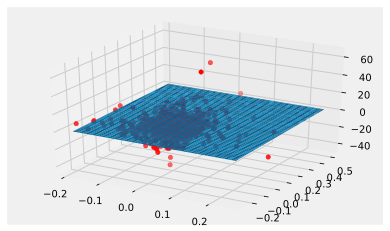

In [58]:
plt3d = plt.figure().gca(projection="3d")
plt3d.plot_surface(delta_btc_xx, delta_eth_yy, z)
plt3d.scatter(X3["Delta Bitcoin"],X3["Delta Ethereum"], Y , color="r")

Analise semanal das variações:

In [54]:
#Ouro = Ouro.assign(Date=pd.to_datetime(Ouro['Date']))
Ouro["Delta Ouro"] = (Ouro["Price"] - Ouro["Open"])/Ouro["Open"]
#Ouro.set_index('Date',inplace = True)

In [55]:
Ouro_Semanal = pd.DataFrame({'Date':pd.date_range('2013-05-01', '2018-11-01', freq='7d')})
Ouro_Semanal.set_index('Date',inplace = True)
Ouro_Semanal = Ouro_Semanal.join(Ouro['Price'])
Ouro_Semanal  = Ouro_Semanal.pct_change().dropna()
Ouro_Semanal.head()

,Price
Date,
2013-05-08,0.010428
2013-05-15,-0.054250
2013-05-22,-0.016871
2013-05-29,0.017197
2013-06-05,0.007430


In [59]:
bitcoin_market_info_Semanal = pd.DataFrame({'Date':pd.date_range('2013-05-01', '2018-11-01', freq='7d')})
bitcoin_market_info_Semanal.set_index('Date',inplace = True)
bitcoin_market_info_Semanal = bitcoin_market_info_Semanal.join(bitcoin_market_info['Close'])
bitcoin_market_info_Semanal.head()

,Close
Date,
2013-05-01,116.99
2013-05-08,113.57
2013-05-15,114.22
2013-05-22,123.89
2013-05-29,132.30


In [61]:
bitcoin_market_info_Semanal  = bitcoin_market_info_Semanal.pct_change().dropna()

In [63]:
Semanal = bitcoin_market_info_Semanal.join(Ouro_Semanal, how='inner', lsuffix='_btc', rsuffix='_gold').dropna()
Y = Semanal['Close']#DeltaBit
X = Semanal['Price']#PreçoMensal
Resultado = regress_sem_const(X,Y)
Resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.310
Date:                Thu, 22 Nov 2018   Prob (F-statistic):            0.00727
Time:                        23:08:22   Log-Likelihood:                -957.61
No. Observations:                 286   AIC:                             1917.
Df Residuals:                     285   BIC:                             1921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price         58.7106     21.715      2.704      0.007      15.968     101.454
==============================================================================
Omnibus:                      195.322   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5692.778
Skew:                           2.268   Prob(JB):                         0.00
Kurtosis:                      24.381   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Com constante:

In [64]:
Resultado = regress_com_const(X,Y)
Resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.284
Date:                Thu, 22 Nov 2018   Prob (F-statistic):            0.00737
Time:                        23:09:21   Log-Likelihood:                -957.61
No. Observations:                 286   AIC:                             1919.
Df Residuals:                     284   BIC:                             1927.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0141      0.409      0.035      0.972      -0.790       0.819
Price         58.7305     21.761      2.699      0.007      15.897     101.564
==============================================================================
Omnibus:                      195.326   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5692.476
Skew:                           2.268   Prob(JB):                         0.00
Kurtosis:                      24.380   Cond. No.                         53.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Tabela mensal:

In [65]:
Ouro_Mensal = pd.DataFrame({'Date':pd.date_range('2013-05-01', '2018-11-01', freq='30d')})
Ouro_Mensal.set_index('Date',inplace = True)
Ouro_Mensal = Ouro_Mensal.join(Ouro['Price']).dropna()
Ouro_Mensal = Ouro_Mensal.pct_change().dropna()
Ouro_Mensal.head()

,Price
Date,
2013-05-31,-0.048504
2013-07-30,-0.042974
2013-08-29,0.060988
2013-10-28,-0.039801
2013-11-27,-0.084899


In [66]:
bitcoin_market_info_Mensal = pd.DataFrame({'Date':pd.date_range('2013-05-01', '2018-11-01', freq='30d')})
bitcoin_market_info_Mensal.set_index('Date',inplace = True)
bitcoin_market_info_Mensal = bitcoin_market_info_Mensal.join(bitcoin_market_info['Close']).dropna()
bitcoin_market_info_Mensal = bitcoin_market_info_Mensal.pct_change().dropna()
bitcoin_market_info_Mensal.head()

,Close
Date,
2013-05-31,0.102658
2013-06-30,-0.251085
2013-07-30,0.117793
2013-08-29,0.133346
2013-09-28,0.101234


Regressão sem constante:

In [67]:
Mensal = bitcoin_market_info_Mensal.join(Ouro_Mensal, how='inner', lsuffix='_btc', rsuffix='_gold').dropna()
Y = Mensal['Close']#DeltaBit
X = Mensal['Price']#PreçoMensal
Resultado = regress_sem_const(X,Y)
Resultado.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     4.338
Date:                Thu, 22 Nov 2018   Prob (F-statistic):             0.0426
Time:                        23:12:04   Log-Likelihood:                -45.867
No. Observations:                  49   AIC:                             93.73
Df Residuals:                      48   BIC:                             95.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price         -3.8293      1.839     -2.083      0.043      -7.526      -0.133
==============================================================================
Omnibus:                       80.801   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1266.230
Skew:                           4.367   Prob(JB):                    1.10e-275
Kurtosis:                      26.322   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regressão com constante:

In [68]:
Mensal = bitcoin_market_info_Mensal.join(Ouro_Mensal, how='inner', lsuffix='_btc', rsuffix='_gold').dropna()
Y = Mensal['Close']#DeltaBit
X = Mensal['Price']#PreçoMensal
Resultado = regress_com_const(X,Y)
Resultado.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.194
Date:                Thu, 22 Nov 2018   Prob (F-statistic):             0.0462
Time:                        23:14:10   Log-Likelihood:                -44.043
No. Observations:                  49   AIC:                             92.09
Df Residuals:                      47   BIC:                             95.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1654      0.087      1.906      0.063      -0.009       0.340
Price         -3.6701      1.792     -2.048      0.046      -7.275      -0.065
==============================================================================
Omnibus:                       81.522   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1307.469
Skew:                           4.417   Prob(JB):                    1.22e-284
Kurtosis:                      26.714   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Tabela Semestral:

In [69]:
Ouro_Semestral = pd.DataFrame({'Date':pd.date_range('2013-03-30', '2018-10-31', freq='6m')})
Ouro_Semestral.set_index('Date',inplace = True)
Ouro_Semestral = Ouro_Semestral.join(Ouro['Price'])
Ouro_Semestral = Ouro_Semestral.pct_change().dropna()
Ouro_Semestral.head()

,Price
Date,
2014-03-31,-0.032616
2014-09-30,-0.058408
2015-03-31,-0.021286
2015-09-30,-0.057879
2016-03-31,0.105561


In [70]:
bitcoin_market_info_Semestral = pd.DataFrame({'Date':pd.date_range('2013-03-30', '2018-10-31', freq='6m')})
bitcoin_market_info_Semestral.set_index('Date',inplace = True)
bitcoin_market_info_Semestral = bitcoin_market_info_Semestral.join(bitcoin_market_info['Close']).dropna()
bitcoin_market_info_Semestral = bitcoin_market_info_Semestral.pct_change().dropna()
bitcoin_market_info_Semestral.head()

,Close
Date,
2014-03-31,2.436090
2014-09-30,-0.153304
2015-03-31,-0.368843
2015-09-30,-0.033412
2016-03-31,0.765356


Regressão com constante:

In [74]:
Semestral = bitcoin_market_info_Semestral.join(Ouro_Semestral, how='inner', lsuffix='_btc', rsuffix='_gold').dropna()
Y = Semestral['Close']#DeltaBit
X = Semestral['Price']#PreçoMensal
Resultado = regress_com_const(X,Y)
Resultado.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.140
Method:                 Least Squares   F-statistic:                    0.1428
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.718
Time:                        23:17:05   Log-Likelihood:                -9.8670
No. Observations:                   8   AIC:                             23.73
Df Residuals:                       6   BIC:                             23.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5029      0.346      1.454      0.196      -0.343       1.349
Price          2.1814      5.772      0.378      0.718     -11.942      16.305
==============================================================================
Omnibus:                       11.561   Durbin-Watson:                   1.430
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                3.967
Skew:                           1.576   Prob(JB):                        0.138
Kurtosis:                       4.404   Cond. No.                         17.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regressão sem constante:

In [75]:
Semestral = bitcoin_market_info_Semestral.join(Ouro_Semestral, how='inner', lsuffix='_btc', rsuffix='_gold').dropna()
Y = Semestral['Close']#DeltaBit
X = Semestral['Price']#PreçoMensal
Resultado = regress_sem_const(X,Y)
Resultado.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.142
Method:                 Least Squares   F-statistic:                  0.007535
Date:                Thu, 22 Nov 2018   Prob (F-statistic):              0.933
Time:                        23:17:52   Log-Likelihood:                -11.074
No. Observations:                   8   AIC:                             24.15
Df Residuals:                       7   BIC:                             24.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Price          0.5288      6.092      0.087      0.933     -13.877      14.935
==============================================================================
Omnibus:                        9.267   Durbin-Watson:                   1.097
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                3.033
Skew:                           1.415   Prob(JB):                        0.219
Kurtosis:                       4.045   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""